<a href="https://colab.research.google.com/github/tomiambro/ap_automatico/blob/tps-tomi/tp1v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.cluster import hierarchy as hc
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA

#Otros 
import warnings
warnings.filterwarnings('ignore')

## Descargar y descomprimir el dataset

El archivo se va a descargar en el path 'root_path'

In [40]:
root_path = 'gdrive/MyDrive/machine_learning/ap_automatico'  # Modificar con el nombre de la carpeta donde vayas a bajar los datos

In [41]:
# download dataset
import requests
from os.path import exists

if not exists(f"{root_path}/dataset_aditional.zip"): 
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
  r = requests.get(url, allow_redirects=True)

  open(f"{root_path}/dataset.zip", 'wb').write(r.content)

In [42]:
# unzip dataset

if not exists(f"{root_path}/dataset_aditional.zip"): 
  import zipfile
  with zipfile.ZipFile(f"{root_path}/dataset.zip", 'r') as zip_ref:
      zip_ref.extractall(root_path)

## Cargamos el dataset en un DataFrame

In [43]:
from sklearn.preprocessing import label_binarize

In [44]:
df_raw = pd.read_csv(f"{root_path}/bank-additional/bank-additional-full.csv", delimiter=';')
df_raw.tail(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [45]:
df_raw.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Revisamos que no falten datos

In [46]:
df_raw.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Descartamos la columna 'duration' segun lo especificado por las notas del dataset:

'*duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*'

In [47]:
# df = df_raw.drop('duration', axis=1)
df = df_raw[df_raw['duration'] > 0]
df.shape, df_raw.shape

((41184, 21), (41188, 21))

In [48]:
df['pdays'] = df['pdays'].replace(999, -1)
df['pdays'].max()

27

### Pasamos las columnas que tienen datos categoricos a variables numericas

In [49]:
# Primero pasamos nuestra 'y'
df.loc[:, 'y'] = label_binarize(df['y'], classes=['no', 'yes'])
df.tail(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,-1,1,failure,-1.1,94.767,-50.8,1.028,4963.6,0


In [50]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for col in cat_cols:
  print(col)
  print(pd.Categorical(df[col]).categories)
  df.loc[:, col] = pd.Categorical(df[col]).codes

df.tail(5) 

job
Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')
marital
Index(['divorced', 'married', 'single', 'unknown'], dtype='object')
education
Index(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
       'professional.course', 'university.degree', 'unknown'],
      dtype='object')
default
Index(['no', 'unknown', 'yes'], dtype='object')
housing
Index(['no', 'unknown', 'yes'], dtype='object')
loan
Index(['no', 'unknown', 'yes'], dtype='object')
contact
Index(['cellular', 'telephone'], dtype='object')
month
Index(['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'], dtype='object')
day_of_week
Index(['fri', 'mon', 'thu', 'tue', 'wed'], dtype='object')
poutcome
Index(['failure', 'nonexistent', 'success'], dtype='object')


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,5,1,5,0,2,0,0,7,0,334,1,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,1,1,5,0,0,0,0,7,0,383,1,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,5,1,6,0,2,0,0,7,0,189,2,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,9,1,5,0,0,0,0,7,0,442,1,-1,0,1,-1.1,94.767,-50.8,1.028,4963.6,1
41187,74,5,1,5,0,2,0,0,7,0,239,3,-1,1,0,-1.1,94.767,-50.8,1.028,4963.6,0


In [51]:
df.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.00000,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000
mean,40.023529,3.724796,1.172810,3.747208,0.208892,1.071678,0.327457,0.365263,4.230963,2.004638,258.310096,2.567381,-0.741963,0.172980,0.930094,0.08192,93.575686,-40.502508,3.621337,5167.037145,0.112665
std,10.421044,3.594638,0.608903,2.136534,0.406701,0.985316,0.723644,0.481510,2.319957,1.397582,259.279344,2.769895,1.510398,0.494922,0.362903,1.57096,0.578849,4.628128,1.734438,72.252762,0.316187
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,-3.40000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,102.000000,1.000000,-1.000000,0.000000,1.000000,-1.80000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.000000,2.000000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,180.000000,2.000000,-1.000000,0.000000,1.000000,1.10000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,7.000000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,319.000000,3.000000,-1.000000,0.000000,1.000000,1.40000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.000000,11.000000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,4918.000000,56.000000,27.000000,7.000000,2.000000,1.40000,94.767000,-26.900000,5.045000,5228.100000,1.000000


## EDA

### Heatmap

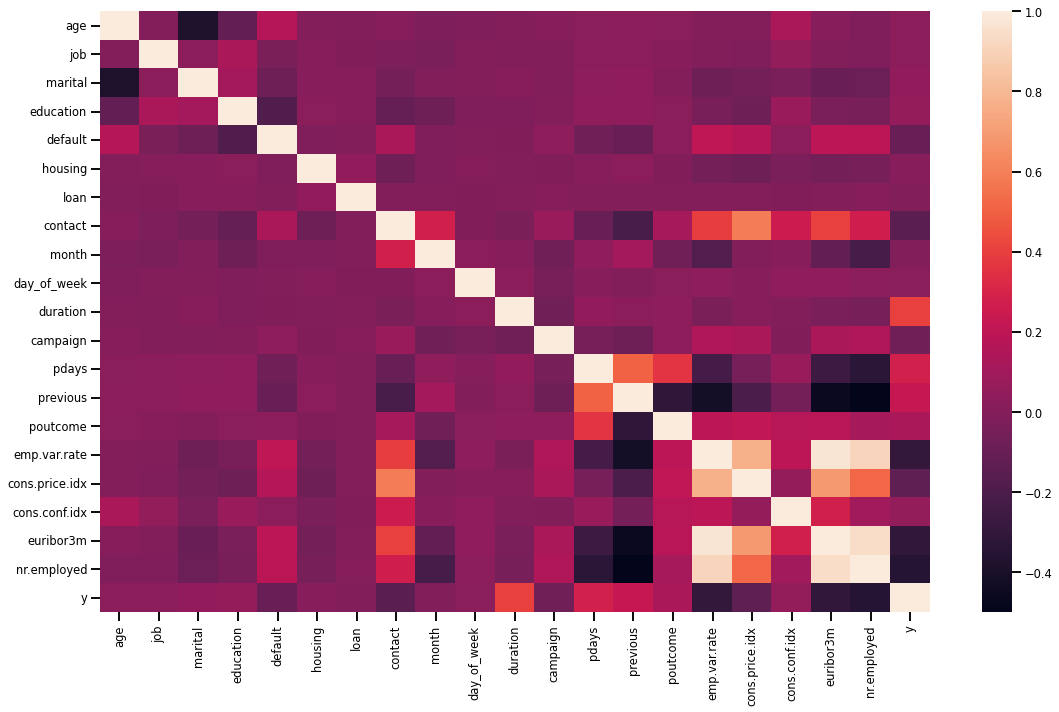

In [52]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr())
plt.tight_layout()

### Boxplot

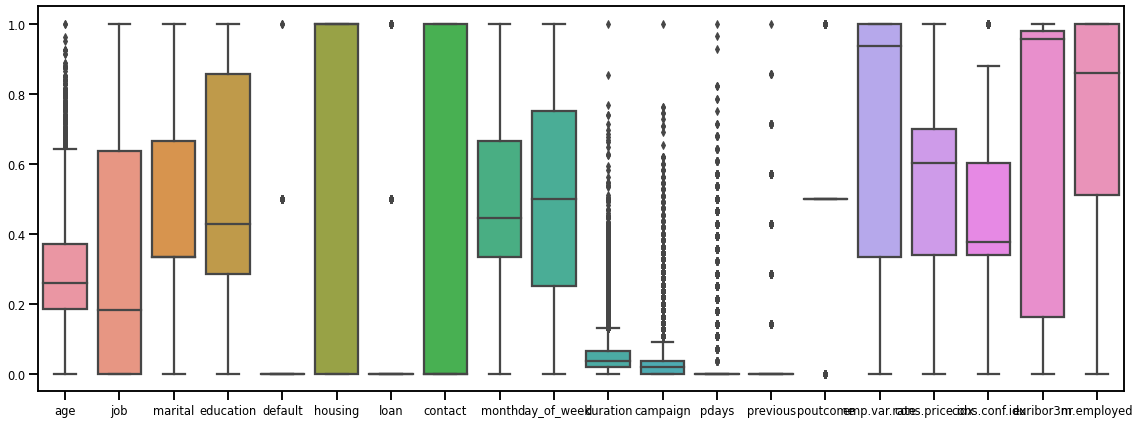

In [53]:
scal = MinMaxScaler()
df_normal = scal.fit_transform(df.drop('y', axis=1))
cols = df.columns
cols = cols.drop('y')
df_normal = pd.DataFrame(df_normal, columns=cols)

plt.figure(figsize=(16,6))
sns.boxplot(data=df_normal)
plt.tight_layout()
plt.show()

<Figure size 1152x1224 with 0 Axes>

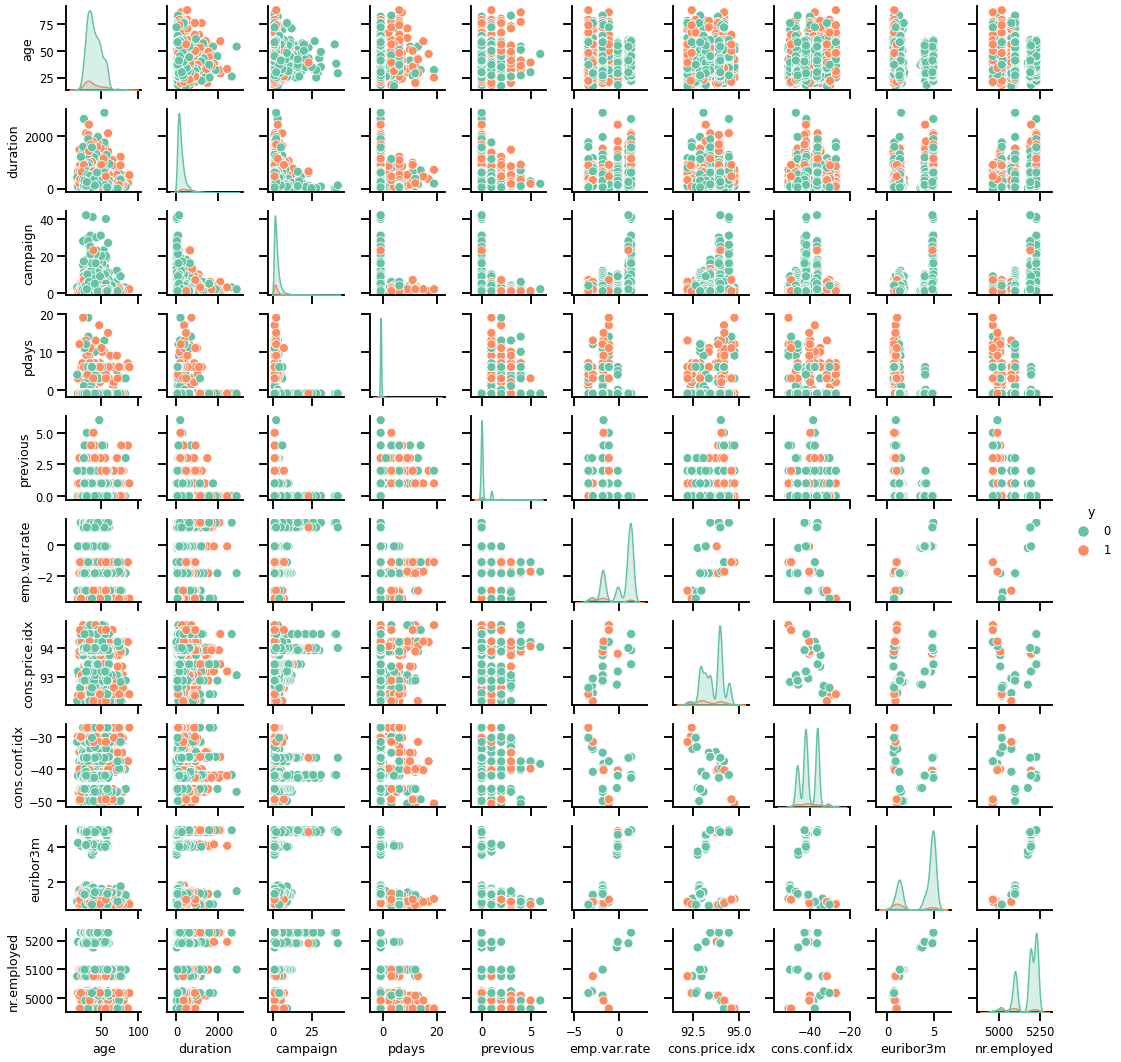

In [54]:
plt.figure(figsize=(16,17))
g = sns.pairplot(data=df.drop(cat_cols, axis=1).sample(frac=0.1, random_state=42), hue='y', palette='Set2', height=1.5)

g.tight_layout()
plt.show()

In [55]:
scal = StandardScaler()
df_scal = scal.fit_transform(df.drop('y', axis=1))

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scal)
xpca = pd.DataFrame(df_pca)

In [56]:
df['y'] == 'yes'

0        False
1        False
2        False
3        False
4        False
         ...  
41183    False
41184    False
41185    False
41186    False
41187    False
Name: y, Length: 41184, dtype: bool

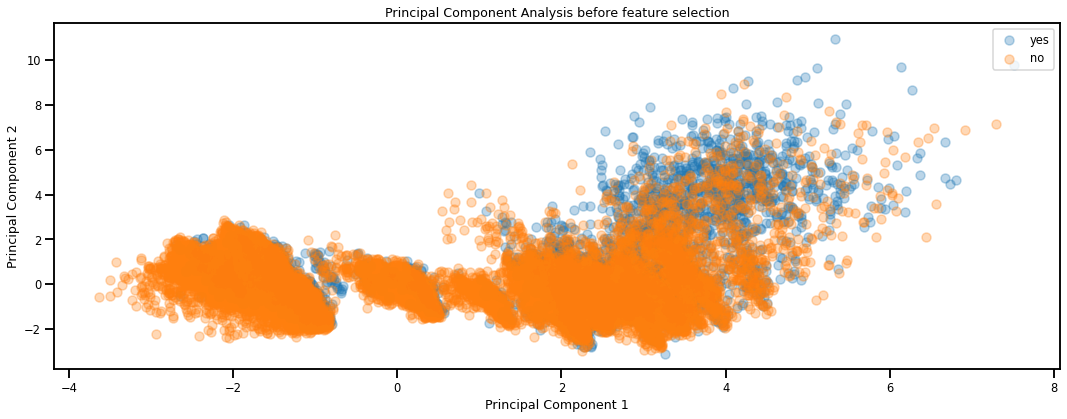

In [57]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))

plt.scatter(xpca.loc[(df['y'] == 1).ravel(),0],xpca.loc[(df['y'] == 1).ravel(),1], alpha = 0.3, label = 'yes')
plt.scatter(xpca.loc[(df['y'] == 0).ravel(),0],xpca.loc[(df['y'] == 0).ravel(),1], alpha = 0.3, label = 'no')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

A simple vista no parecen ser linealmente separables

## Entrenamos algunos modelos

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve

### Revisamos el balance entre clases

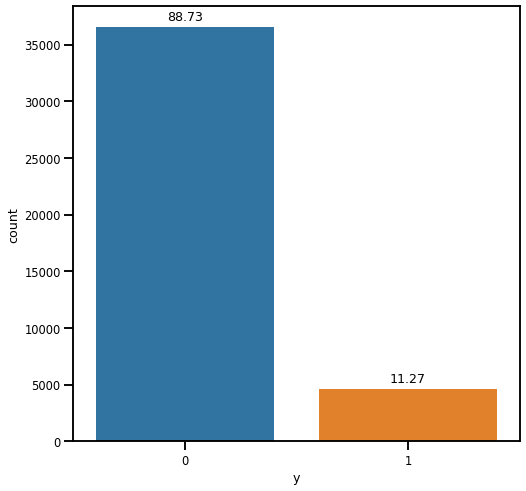

In [59]:
plt.figure(figsize=(8,8))
splot = sns.countplot(x='y', data=df)

for p in splot.patches:
    splot.annotate(format(p.get_height()/df.shape[0]*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

Dado que hay un claro desbalance elegimos las metricas de area bajo la curva ROC y el valor F1 para una correcta interpretacion de la utilidad del modelo.

### Particionamos el dataset en train y test

In [60]:
X = df.drop('y', axis=1)
y = df['y']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

### Modelo de base

Definimos los modelos que vamos a entrenar

In [61]:
ytests = {}
ypreds = {}
m = {}

res = pd.DataFrame({'model':[], 'roc validation':[], 'roc test':[], 'f1 test':[]})

models = {
        'Logistic Regression': LogisticRegression(n_jobs = -1, random_state=1, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(300, n_jobs = -1, random_state=1, class_weight='balanced'),
        'SVC': SVC(random_state=1, class_weight='balanced'),
        'KNNeighbors': KNeighborsClassifier(n_jobs = -1),
        'LDA': LinearDiscriminantAnalysis()
}

In [62]:
scal = MinMaxScaler()
xtrain_scal = scal.fit_transform(xtrain)
xtest_scal = scal.transform(xtest)

In [63]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
scores = cross_val_score(dc, xtrain_scal, ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
dc.fit(xtrain_scal, ytrain)
ypred = dc.predict(xtest_scal)
res = res.append({'model': 'Baseline', 'roc validation': scores.mean(), 'roc test': roc_auc_score(ytest, ypred), 'f1 test': f1_score(ytest, ypred)}, ignore_index=True)
res

,model,roc validation,roc test,f1 test
0,Baseline,0.502407,0.502091,0.113687


In [64]:
def train_models(X, y, xtest, ytest, title=''):
  res = []
  
  for name, model in models.items():
    print(name)
    ytests[f'{name} {title}'] = ytest
    # Model training with cross validation
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    model.fit(X, y)
    
    ypred = model.predict(xtest)
    roc = roc_auc_score(ytest, ypred)
    ypreds[f'{name} {title}'] = ypred
    m[f'{name} {title}'] = model
    
    # Save the results to a dataframe
    # res = res.append(, ignore_index=True)
    res.append({'model': f'{name} {title}', 'roc validation': scores.mean(), 'roc test': roc, 'f1 test': f1_score(ytest, ypred)})
  return res

In [65]:
results = train_models(xtrain_scal, ytrain, xtest_scal, ytest, 'MinMax')
res = res.append(results, ignore_index=True)

Logistic Regression
Random Forest
SVC
KNNeighbors
LDA


In [66]:
res.sort_values('f1 test', ascending=False)

,model,roc validation,roc test,f1 test
3,SVC MinMax,0.936273,0.870224,0.579620
1,Logistic Regression MinMax,0.932242,0.847010,0.563481
5,LDA MinMax,0.928524,0.724450,0.548406
2,Random Forest MinMax,0.947254,0.703861,0.525641
4,KNNeighbors MinMax,0.751243,0.622196,0.368960
0,Baseline,0.502407,0.502091,0.113687


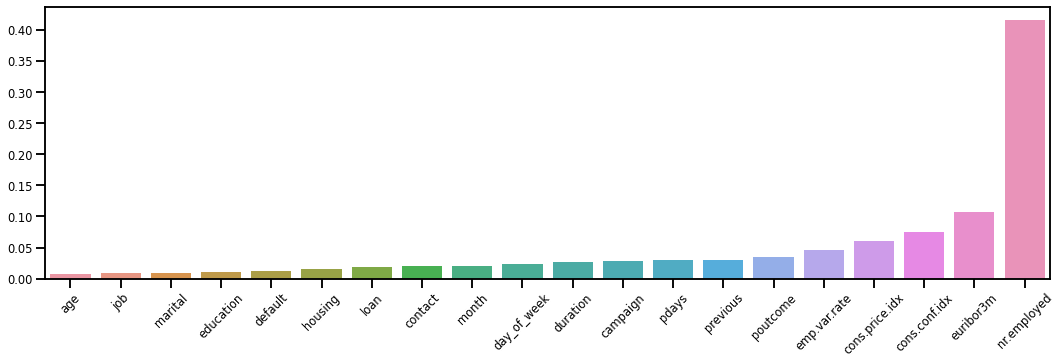

In [67]:
plt.figure(figsize=(18,5))
sns.barplot(df.columns.drop('y'), np.sort(m['Random Forest MinMax'].feature_importances_))
plt.xticks(rotation=45)
plt.show()

### Matriz de confusion del mejor modelo

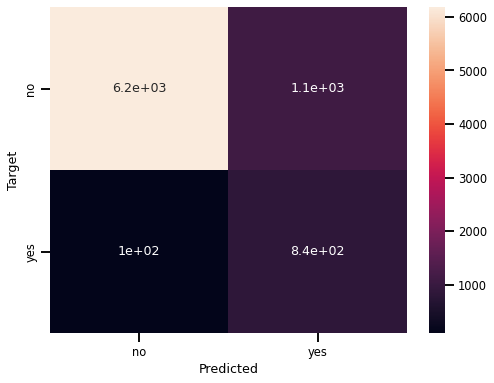

In [73]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(ytests['SVC MinMax'], ypreds['SVC MinMax'])
df_cm = pd.DataFrame(cm, index = ['no', 'yes'], columns = ['no', 'yes'])

sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted') # x-axis label with fontsize 15
plt.ylabel('Target') # y-axis label with fontsize 15
plt.show()